# Análisis de Series Temporales
## Laboratorio 2
### Mario Agustín Sgró

In [1]:
from scipy import stats
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_FILE = 'datasets/demanda.csv'

In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red  = '#D62728'
blue = '#1F77B4'

plt.rcParams['figure.figsize'] = [15, 10]

## Data: Demanda eléctrica de Argentina

En este laboratorio utilizaremos los datos de demanda electrica de Argentina, para el periodo 2013-01 hasta 2019-07.

In [4]:
data = pd.read_csv(DATA_FILE, index_col='TIPO', parse_dates=True)
data.index.name = "Month"
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
Month,,,,
2019-03-01,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04-01,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05-01,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06-01,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07-01,5704951.016,3288949.873,3035538.422,1.202944e+07


In [5]:
data.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,79.00,79.00,79.00,79.00
mean,4551935.29,3113096.42,3187977.02,10853008.74
std,654164.93,206829.98,124659.74,816874.81
min,3239380.70,2809183.13,2897618.67,9307334.16
25%,3990580.45,2948084.14,3109179.19,10223259.40
50%,4470715.12,3070853.24,3199317.20,10706955.32
75%,5092450.46,3270751.91,3275571.56,11476364.98
max,6193110.21,3606989.07,3460879.97,12607552.72


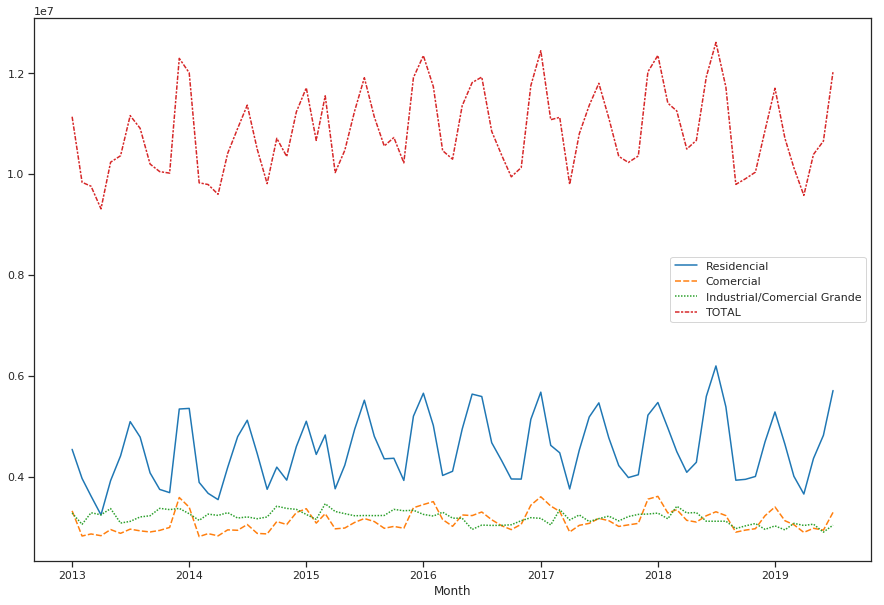

In [6]:
sns.lineplot(data=data);

### Analizamos primero la demanda residencial

In [7]:
ts = data['Residencial'].copy()
ts.index = ts.index.to_period(freq='M')

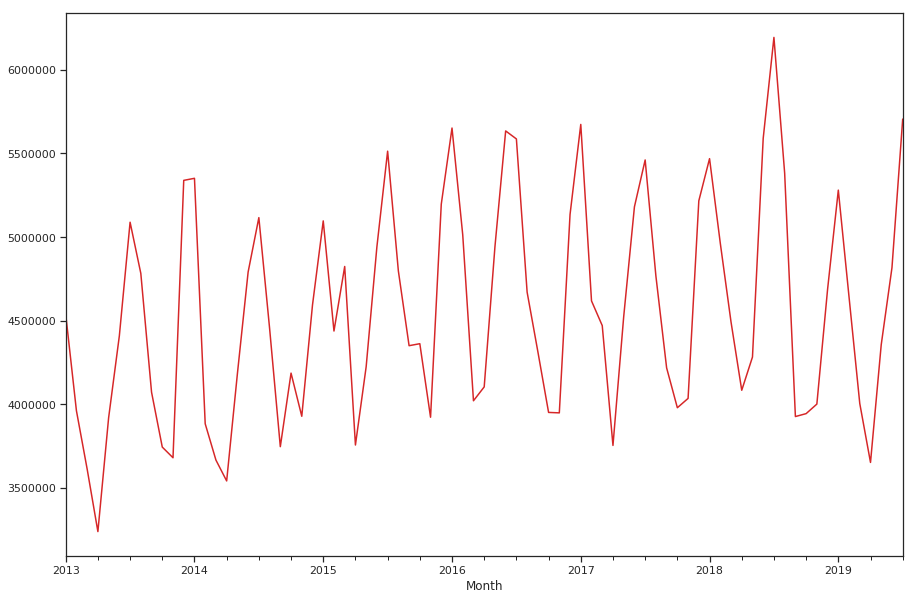

In [8]:
ts.plot(color=red);

## Descoposición de la serie temporal

Realizamos la descomposición de la serie temporal utilizando el algoritmo de X-13 ARIMA-SEATS.

In [9]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/statsmodels/tsa/x13.py:182: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [10]:
[attr for attr in dir(decomposition) if not attr.startswith('_')]

['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

Ploteamos las componentes de la descomposición.

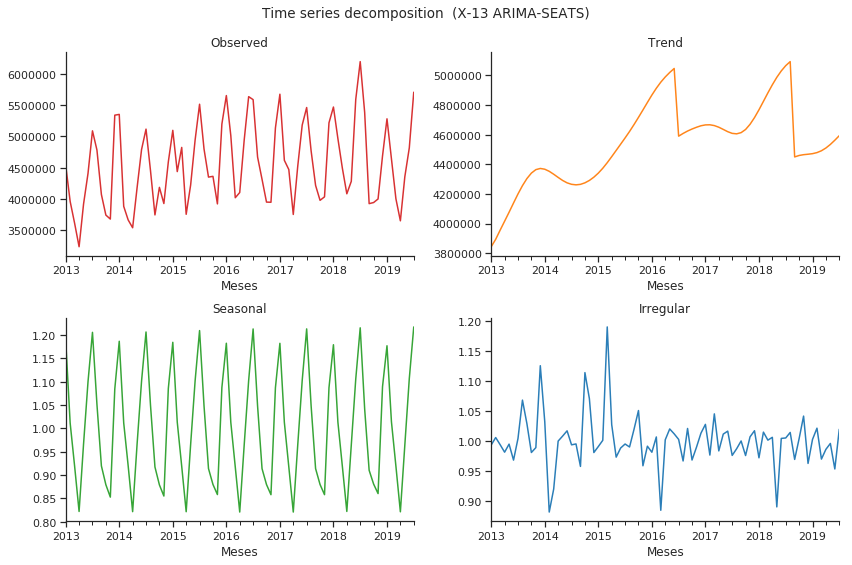

In [11]:
results=decomposition
colours=['#D62728', '#FF7F0E', '#2CA02C', '#1F77B4']
fig, ax = plt.subplots(2,2, figsize=(12,8))

decomposition.observed.plot(ax=ax[0,0],color=colours[0], alpha=0.95)
ax[0,0].set(ylabel='', title='Observed', xlabel='Meses')

decomposition.trend.plot(ax=ax[0,1],color=colours[1], alpha=0.95)
ax[0,1].set(ylabel='', title='Trend', xlabel='Meses')

y = decomposition.observed/decomposition.seasadj
y.plot(ax=ax[1,0],color=colours[2], alpha=0.95)
ax[1,0].set(ylabel='', title='Seasonal', xlabel='Meses')

decomposition.irregular.plot(ax=ax[1,1],color=colours[3], alpha=0.95)
ax[1,1].set(ylabel='', title='Irregular', xlabel='Meses')

sns.despine()
fig.suptitle('Time series decomposition  (X-13 ARIMA-SEATS)', fontsize=13.5)   
fig.tight_layout()
fig.subplots_adjust(top=0.9)

Guardamos los resultados generados por X-13-ARIMA en un archivo para inspección posterior.

In [12]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

## Trend corrected exponential smoothing

Before we model and forecast the original series, the next cells demonstrate the application of the trend corrected exponential smoothing method, focusing on the seasonally adjusted series for coherence. 

In [13]:
z = decomposition.seasadj.copy()
#z.index = ts.index.to_period(freq='M')

In [14]:
model_sm = sm.tsa.Holt(z).fit()
smoothed_sm = model_sm.fittedvalues
mse_sm = sm.tools.eval_measures.rmse(z,smoothed_sm)
print(' In-sample fit:')
print(' RMSE               {0:.3f}'.format(mse_sm))
model_sm.summary()

 In-sample fit:
 RMSE               255748.353


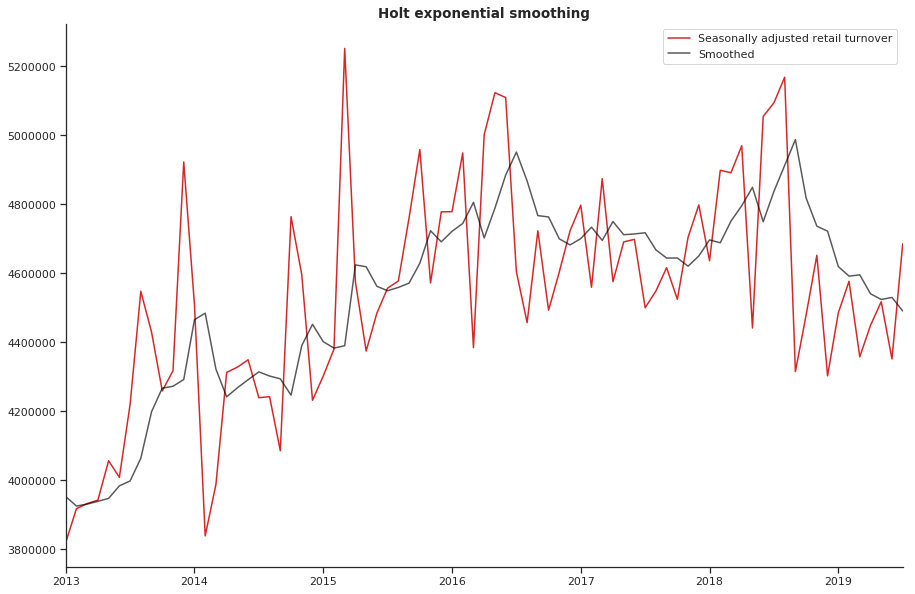

In [15]:
fig, ax= plt.subplots();

z['2013':].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed_sm['2013':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

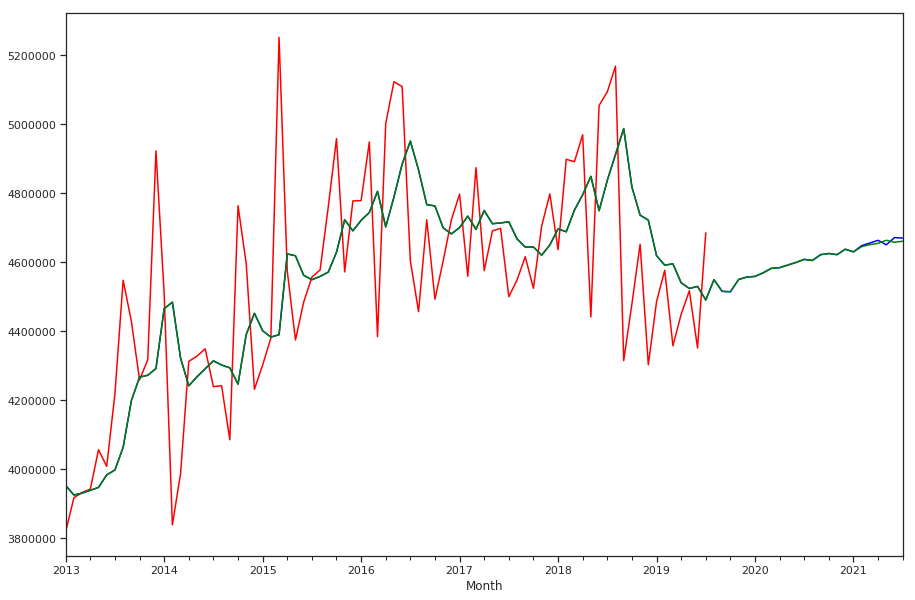

In [16]:
h = 2*12 #M
w = h*4
data = z
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

## Holt-winters exponential smoothing

We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

In [17]:
def hw_summary(model_sm):
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' In-sample fit:')
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return model_sm.summary()

In [18]:
ahw_sm = sm.tsa.ExponentialSmoothing(ts, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [19]:
hw_summary(ahw_sm)

 In-sample fit:
 RMSE               325350.678


In [20]:
mhw_sm = sm.tsa.ExponentialSmoothing(ts, trend='add', damped=False, 
                                     seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm)

 In-sample fit:
 RMSE               249758.947


In [21]:
mhw_damped = sm.tsa.ExponentialSmoothing(ts, trend='add', damped=True, 
                                         seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped)

 In-sample fit:
 RMSE               250884.819


The smoothed series based on the multiplicative method tracks the original series very closely.

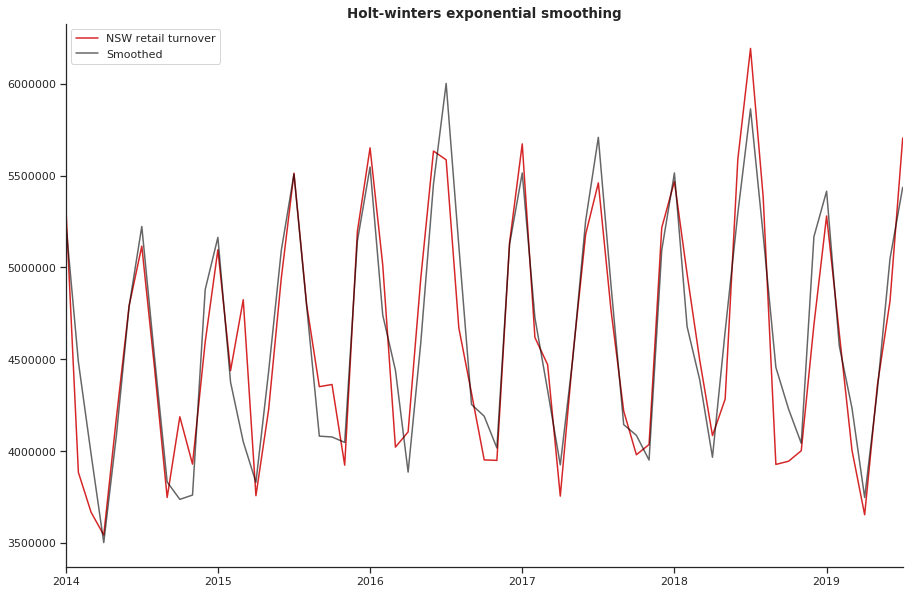

In [22]:
smoothed = pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots();#figsize=(9,6))

ts['2014':].plot(color='#D62728', label='NSW retail turnover')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

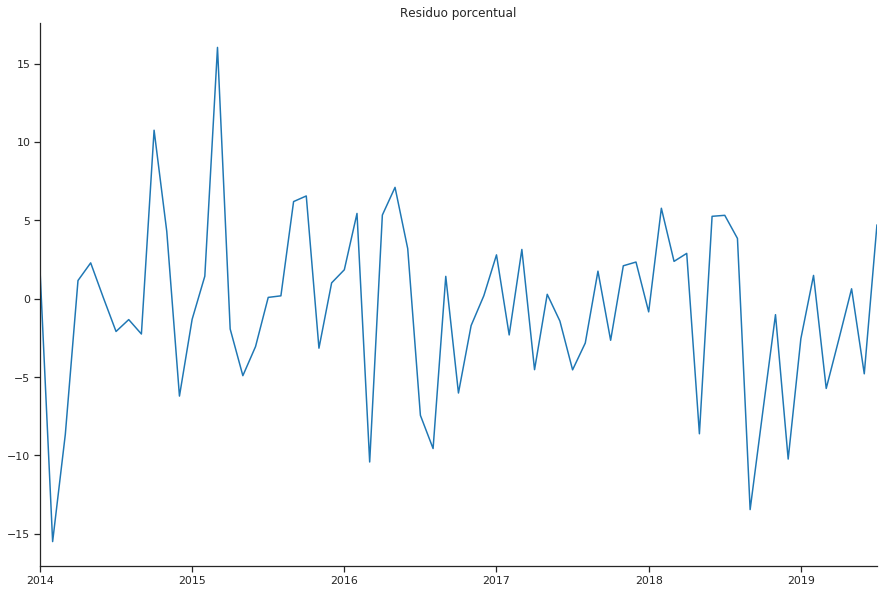

In [23]:
resid = (100.0*(ts - mhw_sm.fittedvalues)/(ts))[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residuo porcentual')
sns.despine()
plt.show()

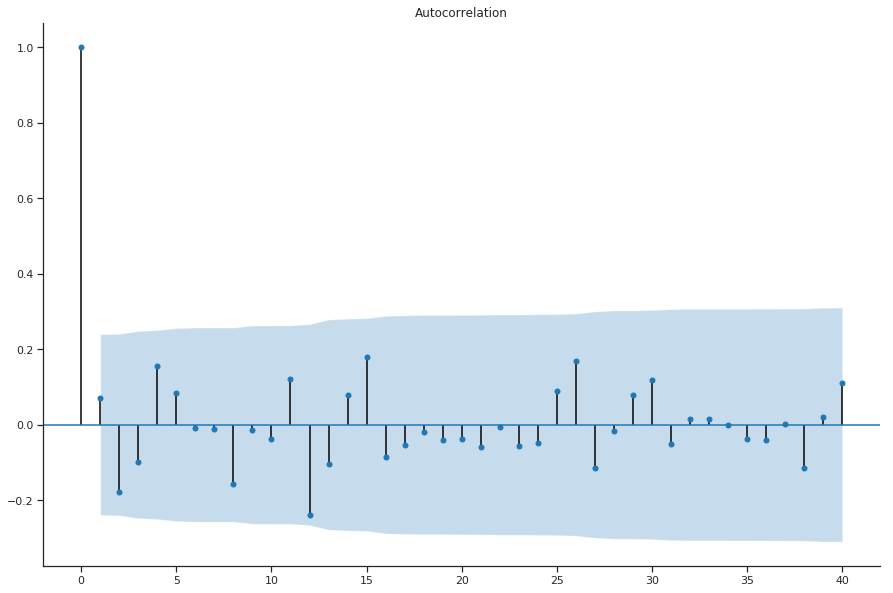

In [24]:
fig, ax = plt.subplots();
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

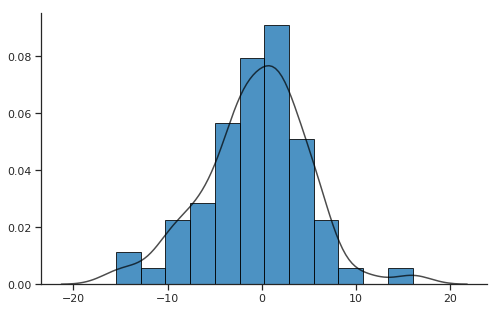

In [25]:
from plotting import histogram

histogram(resid)
plt.show()

## Model validation

The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

In [26]:
start_val = ts.index[-round(len(ts)/12*.2)*12]
start_val

Period('2018-08', 'M')

In [27]:
# Real time forecasting 

validation=ts[start_val:].index
start = ts.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(ts)):
    
    actual.append(ts.iloc[i]) # actual value
    
     # seasonal random walk forecast
    pred1.append(ts.iloc[i-12])
    
     # additive holt winters forecast
    model = sm.tsa.ExponentialSmoothing(ts.iloc[:i], trend='add', damped=False, 
                                        seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0])
    
     # multiplicate holt winters forecast
    model = sm.tsa.ExponentialSmoothing(ts.iloc[:i], trend='add', damped=False, 
                                        seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0])
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [28]:
pred1_err = (np.array(pred1) - np.array(actual))/np.array(actual)
pred2_err = (np.array(pred2) - np.array(actual))/np.array(actual)
pred3_err = (np.array(pred3) - np.array(actual))/np.array(actual)

errors = np.vstack([pred1_err,pred2_err,pred3_err]).T
errors = pd.DataFrame(errors, columns=columns[:-1], index=validation)

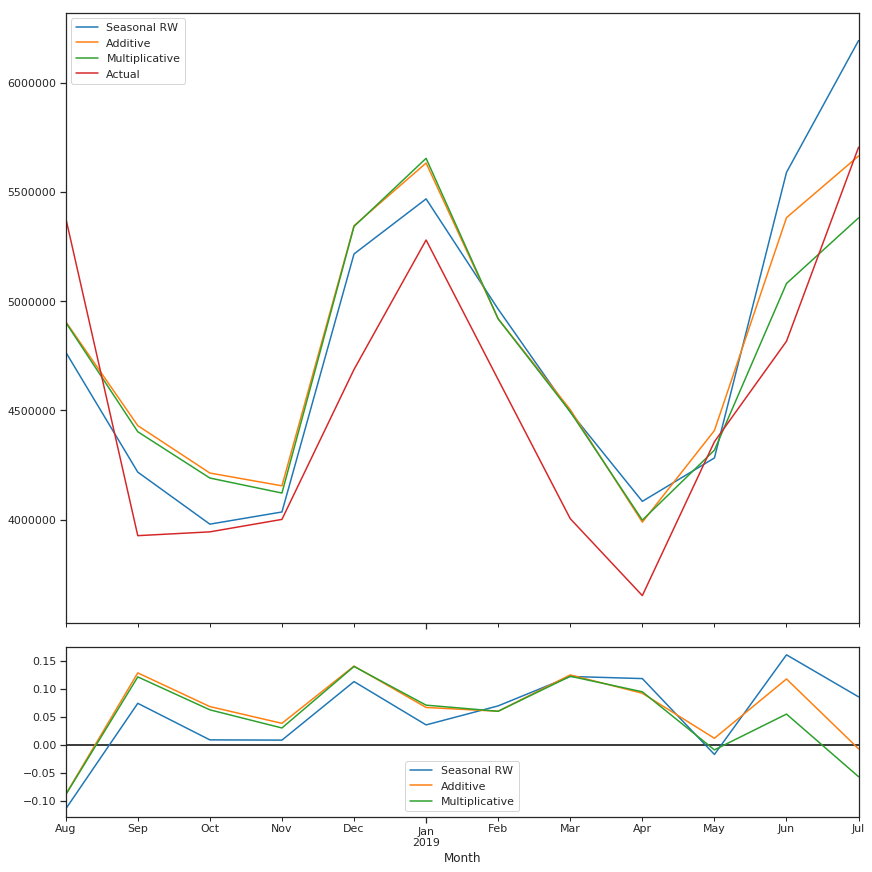

In [29]:
f = plt.figure(constrained_layout=True,figsize=(12,12))

gs = GridSpec(3, 1, figure=f)
ax1 = f.add_subplot(gs[0:2,0])
ax2 = f.add_subplot(gs[2,0],sharex=ax1)

results.plot(ax=ax1)
errors.plot(ax=ax2)
ax2.hlines(0.0,validation.min(),validation.max())

In [30]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,423173.552,104886.183
Additive,397513.457,89958.901
Multiplicative,377600.918,96442.314


## Forecast

Finally, we generate a two year forecast based on the selected model. 

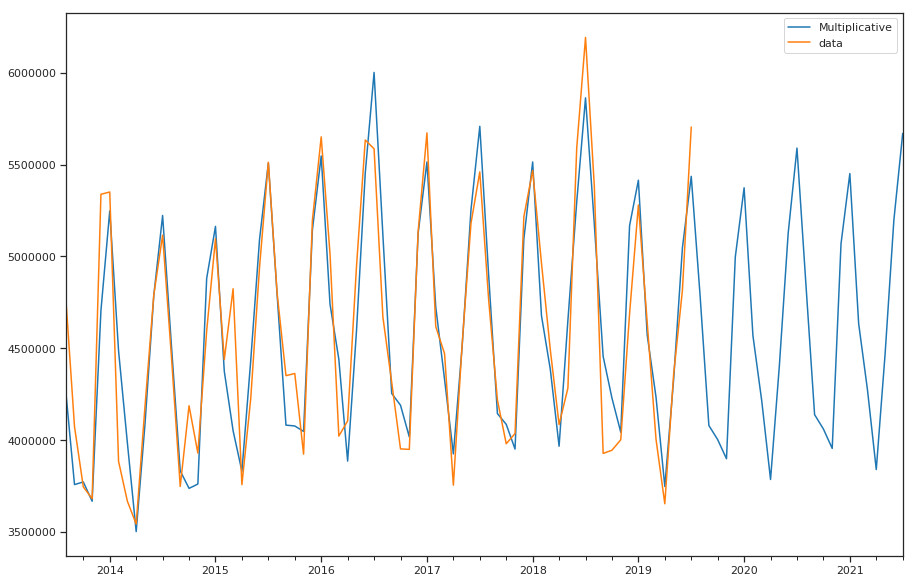

In [31]:
h=2*12 #M
w=h*3

model = sm.tsa.ExponentialSmoothing(ts, trend='add', damped=False, 
                                    seasonal='mul', seasonal_periods=12).fit()

plot = pd.DataFrame()
plot['Multiplicative'] = pd.concat([model.fittedvalues, model.forecast(h)])
plot['data'] = ts

plot[-(w+h):].plot();